# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 
***

**_Project Objective:_**

Take video captures from a car-mounted camera and output video with bounding boxes drawn around surrounding vehicles. This module will be added to the `lane_finder` module, ultimately to be used to better train an autonomous driving model.
***

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Note: for the first two steps, features for training and testing are normalized and randomized.
* Implementation of a sliding-window technique and application of trained classifier to search for vehicles in images.
* Run pipeline on a video stream (initially test_video.mp4, later on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Import Libraries

In [42]:
import cv2
import glob
import time
import pickle
import collections
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load & Explore Data

In [43]:
images = glob.glob('./data/*/*/*.png')
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

In [44]:
# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict 'n_cars' and store the number of car images
    data_dict['n_cars'] = len(cars)
    # Define a key in data_dict "n_notcars" and store the number of car images
    data_dict['n_notcars'] = len(notcars)
    # Read in a test image, either a car or notcar
    car = mpimg.imread(car_list[0])
    # Defince a key 'image_shape' and store the test image shape 3-tuple
    data_dict['image_shape'] = car.shape
    # Defined a key 'data_type' and store the data type of the test image. 
    data_dict['data_type'] = car.dtype
    # Return Data_dict
    return data_dict

data_info = data_look(cars, notcars)

In [45]:
print('Your functions returned a count of',
     data_info['n_cars'], 'cars and', 
     data_info['n_notcars'], 'non-cars')
print('of size:',data_info['image_shape'], 'and data type:',
     data_info['data_type'])

Your functions returned a count of 8792 cars and 8968 non-cars
of size: (64, 64, 3) and data type: float32


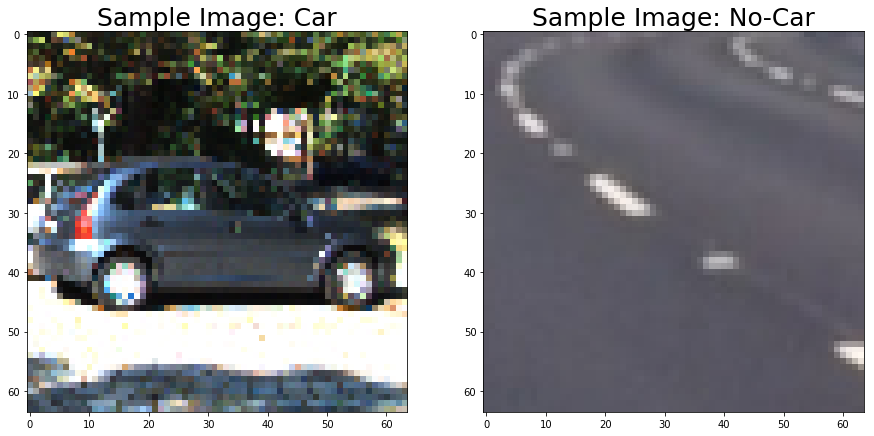

In [194]:
# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(car_image)
ax1.set_title('Sample Image: Car', fontsize=25)
ax2.imshow(notcar_image)
ax2.set_title('Sample Image: No-Car', fontsize=25)
f.savefig('./examples/01-car.noncar.png', bbox_inches='tight')

## Feature Extraction

### Color Histogram

Define Functions

In [195]:
def convert_color(img, color_space='RGB'):
    if color_space !='RGB':
        if color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        if color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        if color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    
    return feature_image
            
            
def color_hist(img, channel='ALL', nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], 
                                    channel2_hist[0], 
                                    channel3_hist[0]))
    if channel==1:
        return channel1_hist
    elif channel==2:
        return channel2_hist
    elif channel==3:
        return channel3_hist
    else:
        return hist_features

Visualize Output

In [196]:
#car image in RGB colorspace & histograms of color channels
car_RGB = convert_color(car_image, color_space='RGB')

#notcar image in HSV colorspace & histograms of color channels
notcar_RGB = convert_color(notcar_image, color_space='RGB')

In [197]:
def show_channels(img, label=None, colorspace=None):
    #show each channel of input image
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
    f.suptitle('Image: %s, Colorspace: %s' % (label, colorspace), fontsize=20)
    ax1.imshow(img[:,:,0])
    ax1.set_title('Channel 1', fontsize=12)
    ax2.imshow(img[:,:,1])
    ax2.set_title('Channel 2', fontsize=12)
    ax3.imshow(img[:,:,2])
    ax3.set_title('Channel 3', fontsize=12)


def show_hist(img, label=None):
    #generate histogram data
    ch1 = color_hist(img, channel=1)
    ch2 = color_hist(img, channel=2)
    ch3 = color_hist(img, channel=3)
    
    #set bin midpoints
    bin_edges = ch1[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    #plot output
    fig = plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.bar(bin_centers, ch1[0], width=0.01)
    plt.xlim(0, 1)
    plt.title('Channel 1 Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, ch2[0], width=0.01)
    plt.xlim(0, 1)
    plt.title('Channel 2 Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, ch3[0], width=0.01)
    plt.xlim(0, 1)
    plt.title('Channel 3 Histogram')

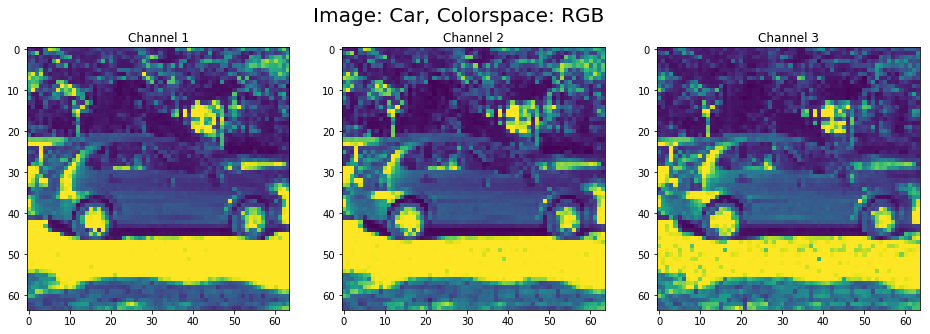

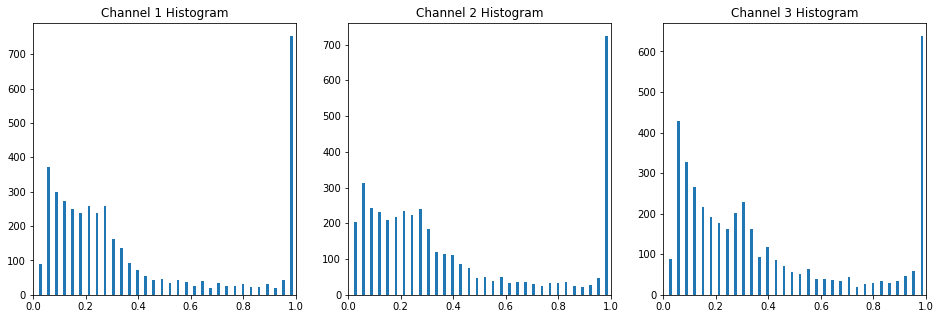

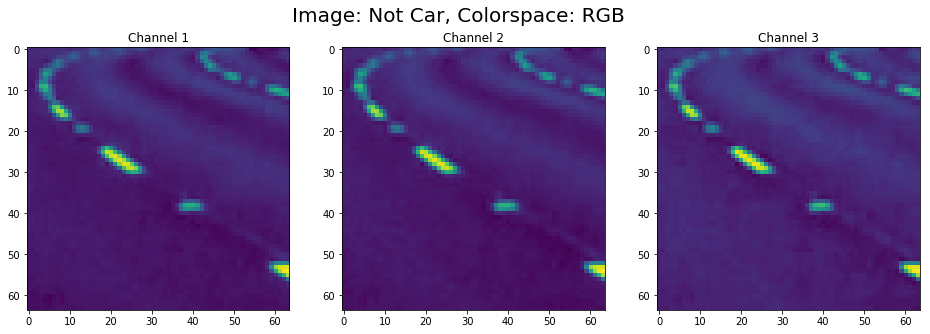

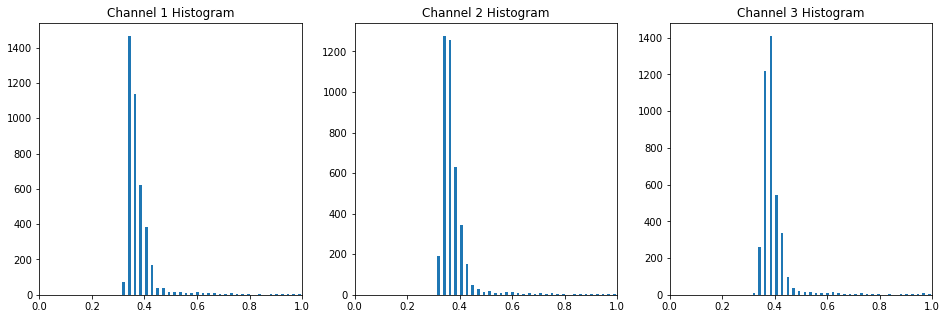

In [198]:
show_channels(car_RGB, label='Car', colorspace='RGB')
show_hist(car_RGB, label='Car')
show_channels(notcar_RGB, label='Not Car', colorspace='RGB')
show_hist(notcar_RGB, label='Not Car')

### Spatial Features

Define Function

In [199]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

Visualize Output

In [200]:
def show_spatial(img, label=None, colorspace=None):
    #generate spatial features vector
    feature_vec = bin_spatial(img)
    
    #show input image and spatially binned features
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    f.suptitle('Image: %s, Colorspace: %s' % (label, colorspace), fontsize=20)
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=12)
    ax2.plot(feature_vec, linewidth=0.5)
    ax2.set_title('Spatial Features', fontsize=12)

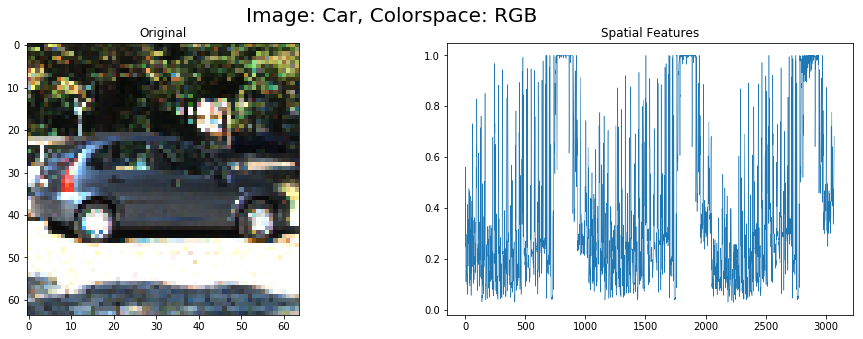

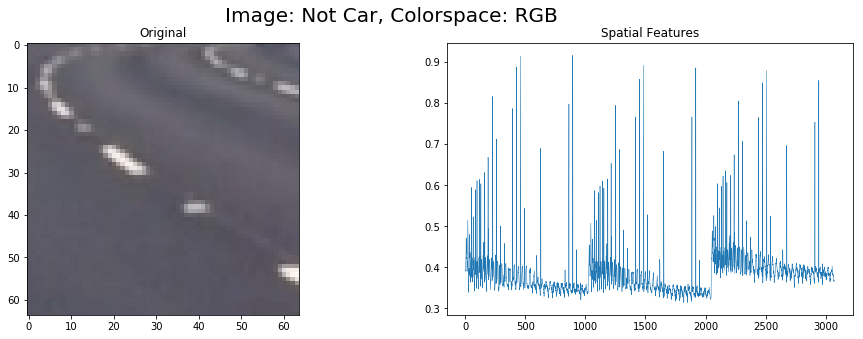

In [201]:
show_spatial(car_RGB, label='Car', colorspace='RGB')
show_spatial(notcar_RGB, label='Not Car', colorspace='RGB')

### HOG Features

Define Function

In [202]:
def get_hog_features(img, orient, 
                     pix_per_cell, 
                     cell_per_block, 
                     vis=False, 
                     feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Visualize Output

In [203]:
def show_hog(img, label=None, colorspace=None):
    #generate hog features and images for each color channel
    hog_feat_ch1, hog_img_ch1 = get_hog_features(img[:,:,0], 
                                                 orient=9, 
                                                 pix_per_cell=8, 
                                                 cell_per_block=2, vis=True)
    hog_feat_ch2, hog_img_ch2 = get_hog_features(img[:,:,1], 
                                                 orient=9, 
                                                 pix_per_cell=8, 
                                                 cell_per_block=2, vis=True)
    hog_feat_ch3, hog_img_ch3 = get_hog_features(img[:,:,2], 
                                                 orient=9, 
                                                 pix_per_cell=8, 
                                                 cell_per_block=2, vis=True)
    
    #display each color channel
    show_channels(img, label=label, colorspace=colorspace)
    
    #display hog images for each color channel
    f1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
    ax1.imshow(hog_img_ch1)
    ax1.set_title('HOG Feature Image, Channel 1', fontsize=12)
    ax2.imshow(hog_img_ch2)
    ax2.set_title('HOG Feature Image, Channel 2', fontsize=12)
    ax3.imshow(hog_img_ch3)
    ax3.set_title('HOG Feature Image, Channel 3', fontsize=12)

    #plot hog feature for each channel
    f2 = plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.plot(hog_feat_ch1, linewidth=0.4)
    plt.title('HOG Features Plot, Channel 1')
    plt.subplot(132)
    plt.plot(hog_feat_ch2, linewidth=0.4)
    plt.title('HOG Features Plot, Channel 2')
    plt.subplot(133)
    plt.plot(hog_feat_ch3, linewidth=0.4)
    plt.title('%s: HOG Features Plot, Channel 3')

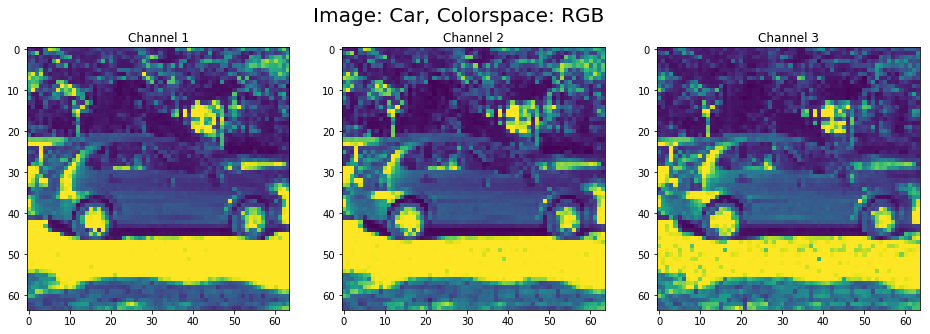

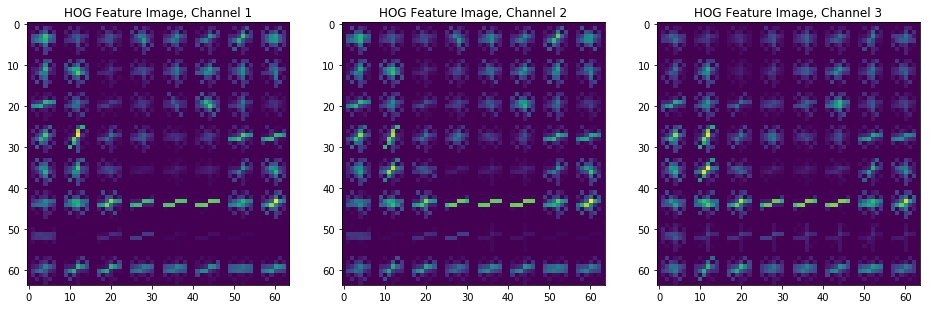

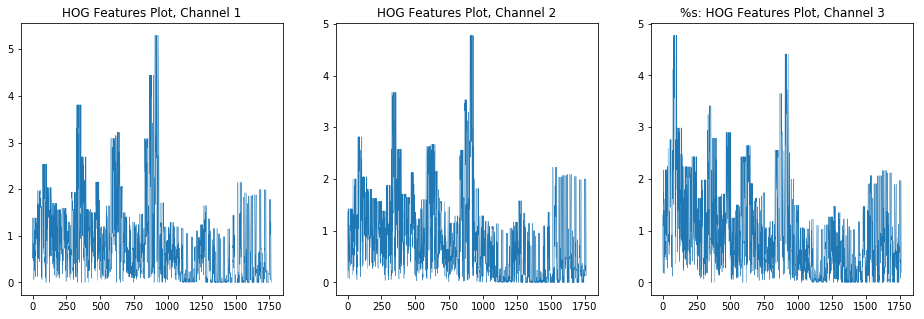

In [204]:
show_hog(car_RGB, label='Car', colorspace='RGB')

### Aggregate Feature Extraction

Define Functions

In [57]:
# Define a function to extract features from a list of images
# This function calls bin_spatial() and color_hist() and get_hog_features()
def extract_features(imgs, color_space='LUV', 
                     spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     color_channel='ALL',
                     hog_channel='ALL',
                     spatial_feat=True, 
                     hist_feat=False, 
                     hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for img in imgs:
        img_features = []
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
        #generate spatial features with bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
            
        if hist_feat == True:
        #generate histogram features with color_hist()
            hist_features = color_hist(feature_image, 
                                       channel=color_channel, 
                                       nbins=hist_bins)
            img_features.append(hist_features)
            
        if hog_feat == True:
        #call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

In [58]:
# Same function as extract_features(), just for
# single image rather than list of images
def single_img_features(img, color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        color_channel='ALL',
                        hog_channel='ALL',
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True):    
    
    #create a list to append feature vectors to
    img_features = []
    
    #apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)   
        
    #compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #append features to list
        img_features.append(spatial_features)
        
    #compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, 
                                   channel=color_channel,
                                   nbins=hist_bins)
        #append features to list
        img_features.append(hist_features)
        
    #compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        #append features to list
        img_features.append(hog_features)

    #return concatenated array of features
    return np.concatenate(img_features)

## Implement Classifier

### Optimize Feature Extraction Parameters

Specify Feature Extraction Parameters to Test

In [211]:
color_space = 'LUV' # Options: RGB, HSV, LAB, LUV, HLS, YUV, YCrCb
spatial_size = (32,32) 
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
color_channel='ALL' # Options: 1, 2, 3, ALL
hog_channel='ALL' # Options: 1, 2, 3, ALL
spatial_feat = True # Include/Exclude => True/False
hist_feat = True # Include/Exclude => True/False
hog_feat = True # Include/Exclude => True/False

Extract Features & Benchmark

In [212]:
t1 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                color_channel=color_channel,
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   orient=orient,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   color_channel=color_channel,
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)
t2 = time.time()
extract_time = round(t2-t1, 2)

Define Label Vectors, Split Data into Randomized Train/Test Sets

In [213]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=rand_state)

Normalize Features

In [214]:
# Fit a per-column scaler on train data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train & X_test
t3 = time.time()
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
t4 = time.time()

scale_time = round(t4-t3, 2)

Train Classifier & Benchmark Parameter Performances

In [215]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t5 = time.time()
svc.fit(scaled_X_train, y_train)
t6 = time.time()
train_time = t6-t5

# Check the score of the SVC
accuracy = round(svc.score(scaled_X_test, y_test), 4) * 100

# Check the prediction time for a single sample
n_predict = 10
t7=time.time()
svc.predict(scaled_X_test[0:n_predict])
t8 = time.time()
predict_time = t8-t7

# Other datapoints
prod_time = extract_time + scale_time + predict_time
efficiency = accuracy / prod_time

In [216]:
# Print feature extraction parameters & performance
print('Feature Extraction Parameters:')
print('______________________________________')
print('Color Space: %21s' % (color_space))
print('Spatial Size: %24s' % (str(spatial_size)))
print('Histogram Bins: %17d' % (hist_bins))
print('Orientation: %19d' % (orient))
print('Pixels per Cell: %15d' % (pix_per_cell))
print('Cells per Block: %15d' % (cell_per_block))
print('Color Channel: %19s' % (str(color_channel)))
print('Color HOG Channel: %15s' % (str(hog_channel)))
print('Include Spatial Features: %9s' % (spatial_feat))
print('Include Histogram Features: %7s' % (hist_feat))
print('Include HOG Features: %13s' % (hog_feat))
print('______________________________________')
print('')
print('')

# Print SVC performance data
print('SVC Performance:')
print('______________________________________')
print('Feature Extraction Time:   %9.1f' % (extract_time))
print('Feature Scaling Time: %14.3f' % (scale_time))
print('Training Time: %21.2f' % (train_time))
print('Predict Time: %22.3f' % (predict_time))
print('Accuracy: %25.1f%%' % (accuracy))
print('Production Time: %19.1f' % (prod_time))
print('Pipeline Efficiency: %15.3f' % (efficiency))
print('______________________________________')

Feature Extraction Parameters:
______________________________________
Color Space:                   LUV
Spatial Size:                 (32, 32)
Histogram Bins:                32
Orientation:                   9
Pixels per Cell:               8
Cells per Block:               2
Color Channel:                 ALL
Color HOG Channel:             ALL
Include Spatial Features:      True
Include Histogram Features:    True
Include HOG Features:          True
______________________________________


SVC Performance:
______________________________________
Feature Extraction Time:       241.1
Feature Scaling Time:          1.660
Training Time:                 30.49
Predict Time:                  0.000
Accuracy:                      98.3%
Production Time:               242.8
Pipeline Efficiency:           0.405
______________________________________


**_Feature Extraction Configuration_**

|Config|Colorspace|Spatial Size|Hist Bins|Orient|Pix/Cell|Cells/Block|Color Channel|HOG Channel|Spatial Feat|Hist Feat|HOG Feat|
|:-:| :-: |:-------:|:--:|:--:| :-: |:-:| :-: | :-: |  :-:  |  :-:  |  :-:  |
| 1 | YCrCb | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 2 | RGB | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 3 | HSV | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 4 | LAB | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 5 | LUV | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 6 | HLS | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 7 | YUV | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | False | False |  True |
| 8 | LUV | (32,32) | 32 |  9 |  8  | 2 | ALL | ALL | True | False |  True |
| 9 | LUV | (32,32) | 32 |  11 |  8  | 2 | ALL | ALL | True | True |  True |
| 10 | LUV | (32,32) | 32 |  11 |  8  | 2 | ALL | ALL | True | False |  True |



**_SVC Performance_**

|Config|Extraction|Scaling|Training|Prediction|Accuracy|Production|Efficiency|
|:-:| :---: |:----:|:----:|:-----:| :---: | :---: | :---: |
| 1 | 186.7 | 1.22 | 31.6 | 0.000 | 95.6% | 187.9 | 0.509 |
| 2 | 256.5 | 1.27 | 49.47 | 0.001 | 92.9 | 257.8 | 0.360 |
| 3 | 255.9 | 1.17 | 32.45 | 0.001 | 95.9% | 257.1 | 0.373 |
| 4 | 233.6 | 1.14 | 28.16 | 0.001 | 95.9% | 234.7 | 0.408 |
| 5 | 152.4 | 1.12 | 31.15 | 0.000 | 95.9% | 152.4 | 0.629 |
| 6 | 158.0 | 1.15 | 34.09 | 0.000 | 95.2% | 159.2 | 0.598 |
| 7 | 158.6 | 1.22 | 28.58 | 0.000 | 95.4% | 158.6 | 0.602 |
| 8 | 149.6 | 1.66 | 35.35 | 0.001 | 97.9% | 151.3 | 0.647 |
| 9 | 261.9 | 1.93 | 31.44 | 0.000 | 98.3% | 263.8 | 0.373 |
| 10 | 159.3 | 1.90 | 39.53 | 0.001 | 97.6% | 161.2 | 0.605 |

Visualizing Effect of Normalization on Raw Feature Vectors

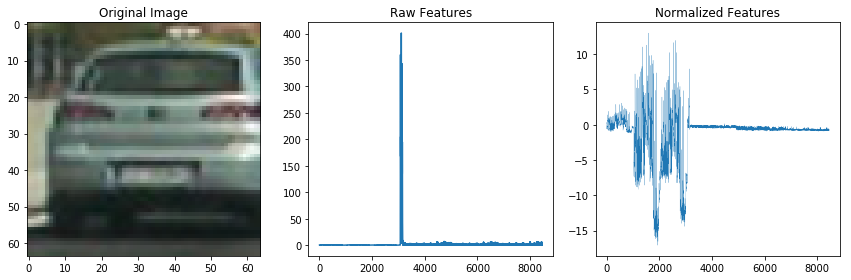

In [63]:
# Plot an example of raw and scaled features
idx = 250
img = mpimg.imread(cars[idx])
features = single_img_features(img)
feat_reshape = features.reshape(1,-1)
scaled_feat = X_scaler.transform(feat_reshape)
scaled_feat_reshape = scaled_feat.reshape(-1)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(132)
plt.plot(features)
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_feat_reshape, linewidth=0.2)
plt.title('Normalized Features')
fig.tight_layout()
#fig.savefig('./examples/xxxxx.png', bbox_inches='tight')

#### Save Data & Parameters to Pickle

In [217]:
# Save trained SVC, scaler and model parameters for later use
dist_pickle = {}
dist_pickle['svc'] = svc
dist_pickle['scaler'] = X_scaler
dist_pickle['color_space'] = color_space
dist_pickle['spatial_size'] = spatial_size
dist_pickle['hist_bins'] = hist_bins
dist_pickle['orient'] = orient
dist_pickle['pix_per_cell'] = pix_per_cell
dist_pickle['cell_per_block'] = cell_per_block
dist_pickle['color_channel'] = color_channel
dist_pickle['hog_channel'] = hog_channel
dist_pickle['spatial_feat'] = spatial_feat
dist_pickle['hist_feat'] = hist_feat
dist_pickle['hog_feat'] = hog_feat
                  
pickle.dump(dist_pickle, open('svc_pickle.p', 'wb' ))

#### Load from Pickle

In [218]:
# Load trained SVC, scaler and model parameters
dist_pickle = pickle.load(open('svc_pickle.p', 'rb'))

svc = dist_pickle['svc'] 
X_scaler = dist_pickle['scaler']
color_space = dist_pickle['color_space']
spatial_size = dist_pickle['spatial_size'] 
hist_bins = dist_pickle['hist_bins']
orient = dist_pickle['orient']
pix_per_cell = dist_pickle['pix_per_cell']
cell_per_block = dist_pickle['cell_per_block']
color_channel = dist_pickle['color_channel'] 
hog_channel = dist_pickle['hog_channel'] 
spatial_feat = dist_pickle['spatial_feat'] 
hist_feat = dist_pickle['hist_feat'] 
hog_feat = dist_pickle['hog_feat'] 

## Detect Cars in Sample Images with SVC

#### Implement Function to Find Cars and Output Bounding Box List

Define Function to Scan Through Subsection of Image

In [68]:
# Define a single function that can extract features
# (hog sub-sampling/spatia/histogram) and make predictions
def find_cars(img, ystart, ystop, scale,
                  svc, X_scaler, 
                  color_space,
                  spatial_size,
                  hist_bins,
                  orient, 
                  pix_per_cell, 
                  cell_per_block,
                  color_channel,
                  hog_channel, 
                  spatial_feat, 
                  hist_feat, 
                  hog_feat, 
                  show_all=False):

    # array where bounding box coordinates of detected cars will be placed
    car_coords = []
    
    # image copy to draw on
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # subsection of image to extract features from
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LAB':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LAB)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      

    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), 
                                      np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, 
                            pix_per_cell, 
                            cell_per_block, 
                            feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, 
                                pix_per_cell, 
                                cell_per_block, 
                                feature_vec=False)
        hog3 = get_hog_features(ch3, orient, 
                                pix_per_cell, 
                                cell_per_block, 
                                feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, 
                                                xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, 
                                       channel=color_channel,
                                       nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, 
                                                          hist_features, 
                                                          hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_coords.append(((xbox_left, ytop_draw+ystart),
                               (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_coords

Define Function to Draw Bounding Boxes on Image

In [69]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    #make a copy of image
    draw_img = np.copy(img)
    #iterate through bounding boxes
    for bbox in bboxes:
        #draw rectangles
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

Test on Sample Images

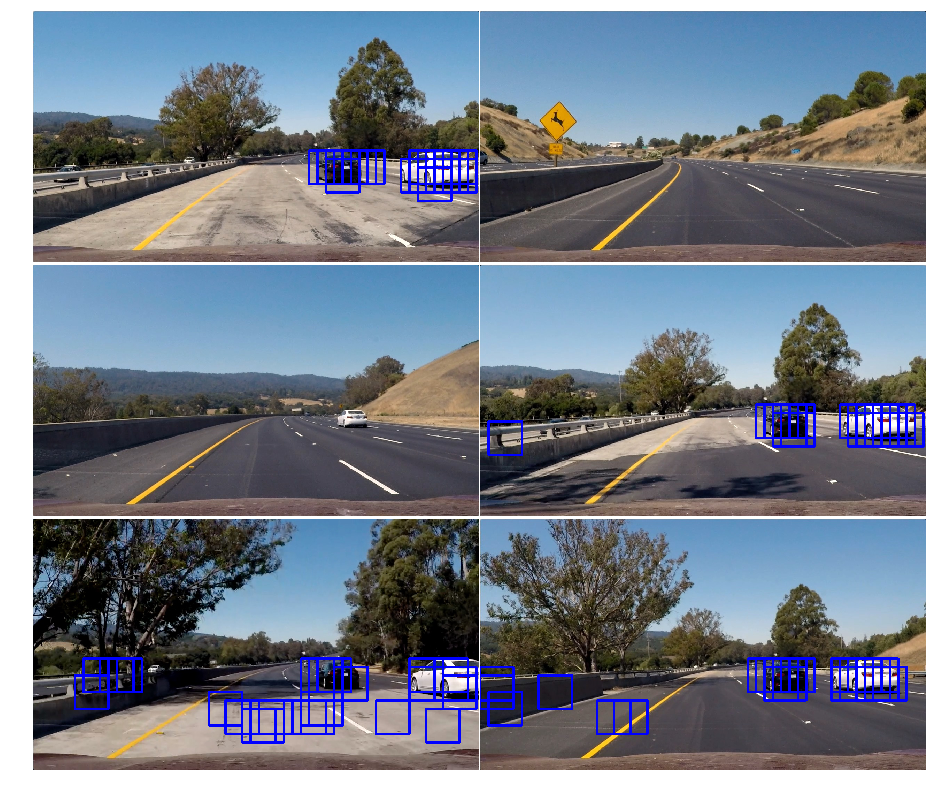

In [219]:
# Make list of images
imgs = glob.glob('./test_images/*')

# Image space parameters
ystart = 400
ystop = 656
scale = 1.5

# Make list of images
imgs = glob.glob('./test_images/*')

# Empty list of output images
output_imgs = []

# Iterate through list of images
for img in imgs:
    # Load image
    sample_img = mpimg.imread(img)

    # Detect cars with find_cars()
    car_boxes = find_cars(sample_img,  
                          ystart=ystart,
                          ystop=ystop,
                          scale=scale,
                          svc=svc, 
                          X_scaler=X_scaler, 
                          color_space=color_space,
                          spatial_size=spatial_size,
                          hist_bins=hist_bins,
                          orient=orient, 
                          pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block,
                          color_channel=color_channel,
                          hog_channel=hog_channel, 
                          spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, 
                          hog_feat=hog_feat)

    # Draw bounding boxes on image
    output_img = draw_boxes(sample_img, car_boxes)
    
    # Add to list
    output_imgs.append(output_img)
    
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace=.004, wspace=.002)
axs = axs.ravel()

for i, img in enumerate(output_imgs):
    axs[i].imshow(img)
    axs[i].axis('off')

#### Specify Multiple Search Dimensions

Set Furthest Areas First then Work Back

In [71]:
# Final search parameters, tested below
# These will feed the pipeline() function, which iterates over these lists
ystart_list = [400, 400, 400, 425, 450, 460]
ystop_list = [500, 540, 575, 625, 700, 720]
scale_list = [1, 1.5, 2, 2.5, 3, 4]

  "matplotlib is currently using a non-GUI backend, "



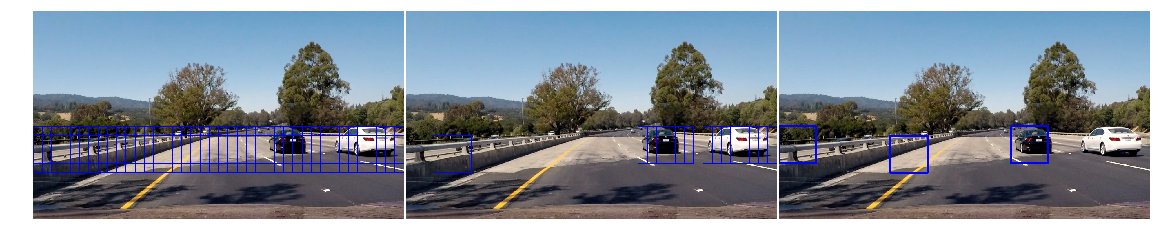

In [246]:
# Image space parameters
ystart = 400
ystop = 575
scale = 2

# Load image
sample_img = mpimg.imread('./test_images/test4.jpg')

# Run find_cars on input image with show_all=True to see all windows
all_windows = find_cars(sample_img,
                      ystart=ystart,
                      ystop=ystop,
                      scale=scale,
                      svc=svc, 
                      X_scaler=X_scaler, 
                      color_space=color_space,
                      spatial_size=spatial_size,
                      hist_bins=hist_bins,
                      orient=orient, 
                      pix_per_cell=pix_per_cell, 
                      cell_per_block=cell_per_block,
                      color_channel=color_channel,
                      hog_channel=hog_channel, 
                      spatial_feat=spatial_feat, 
                      hist_feat=hist_feat, 
                      hog_feat=hog_feat, 
                      show_all=True)

# Run find_cars on input image with show_all=False to see car boxes
car_boxes = find_cars(sample_img,
                      ystart=ystart,
                      ystop=ystop,
                      scale=scale,
                      svc=svc, 
                      X_scaler=X_scaler, 
                      color_space=color_space,
                      spatial_size=spatial_size,
                      hist_bins=hist_bins,
                      orient=orient, 
                      pix_per_cell=pix_per_cell, 
                      cell_per_block=cell_per_block,
                      color_channel=color_channel,
                      hog_channel=hog_channel, 
                      spatial_feat=spatial_feat, 
                      hist_feat=hist_feat, 
                      hog_feat=hog_feat, 
                      show_all=False)


# Draw all windows on image
draw_windows = draw_boxes(sample_img, all_windows, thick=2)

# Draw found boxes on image
found_cars = draw_boxes(sample_img, car_boxes, thick=2)

# Draw subset of region boxes to see how big they are
boxes_subset = all_windows[0::25]
windows_subset = draw_boxes(sample_img, boxes_subset)


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,20))
fig.subplots_adjust(hspace=.004, wspace=.007)
ax1.imshow(draw_windows) #image with all windows
ax1.axis('off')
ax2.imshow(found_cars) #image with 'found car' in 'all windows' region
ax2.axis('off')
ax3.imshow(windows_subset) #subset of 'all windows' to gauge box size
ax3.axis('off')
fig.show()


fig.savefig('./examples/window_search_mid.png', bbox_inches='tight')

## Addressing False Positives & Overlapping Boxes

### Heatmapping Image

Define Function to Convert Bounding Boxes to Heatmap Showing Overlap

In [73]:
# Heatmap function
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

Show Detected Bounding Boxes

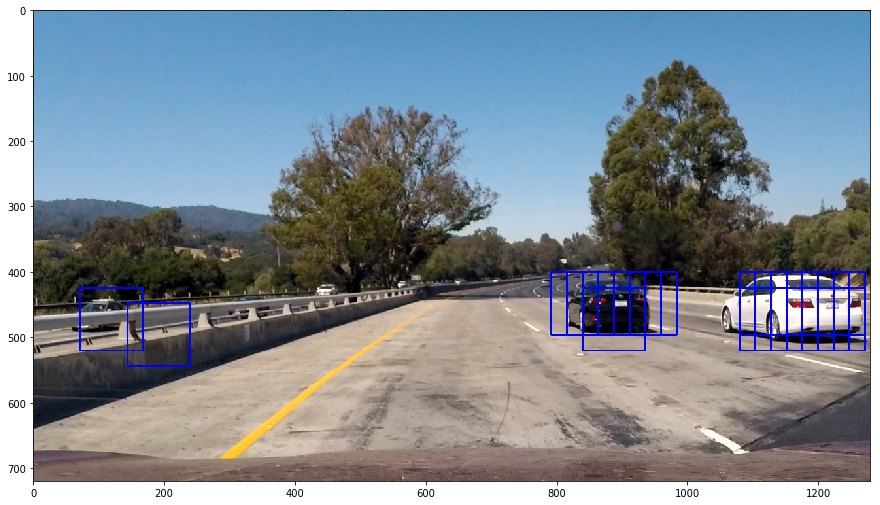

In [74]:
# Image space parameters
ystart = 400
ystop = 675
scale = 1.5

# Load image
sample_img = mpimg.imread('./test_images/test1.jpg')

# Draw bounding box search window on image
car_boxes = find_cars(sample_img,
                      ystart=ystart,
                      ystop=ystop,
                      scale=scale,
                      svc=svc, 
                      X_scaler=X_scaler, 
                      color_space=color_space,
                      spatial_size=spatial_size,
                      hist_bins=hist_bins,
                      orient=orient, 
                      pix_per_cell=pix_per_cell, 
                      cell_per_block=cell_per_block,
                      color_channel=color_channel,
                      hog_channel=hog_channel, 
                      spatial_feat=spatial_feat, 
                      hist_feat=hist_feat, 
                      hog_feat=hog_feat, 
                      show_all=False)

# Draw bounding boxes on image
output_img = draw_boxes(sample_img, car_boxes, thick=2)
plt.figure(figsize=(15,15))
plt.imshow(output_img)
plt.show()

Display Output of add_heat()

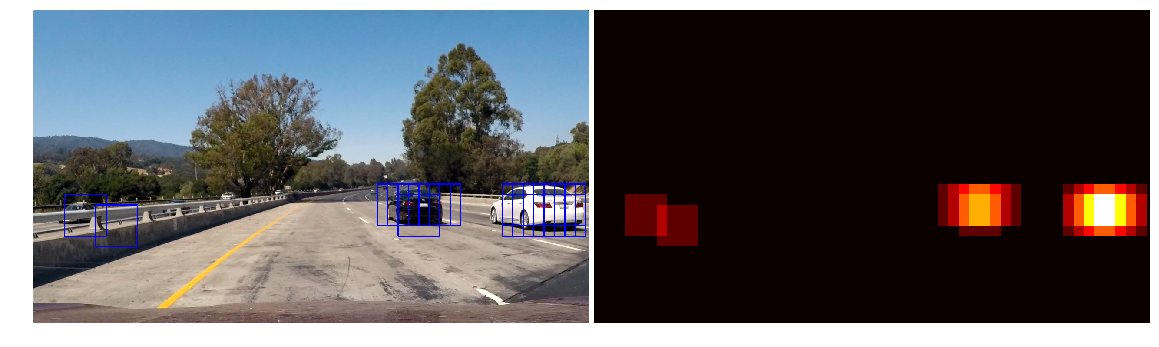

In [182]:
# Display output of add_heat() on sample image
heat_img = np.zeros_like(sample_img[:,:,0])
heat_img = add_heat(heat_img, car_boxes)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
fig.subplots_adjust(hspace=.004, wspace=.01)
ax1.imshow(output_img) #image with boxes
ax1.axis('off')
ax2.imshow(heat_img, cmap='hot') #heatmap
ax2.axis('off')

fig.savefig('./examples/heatmap.png', bbox_inches='tight')

### Apply Threshold to Heatmap

Define Thresholding Function

In [76]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Show Output of apply_threshold()

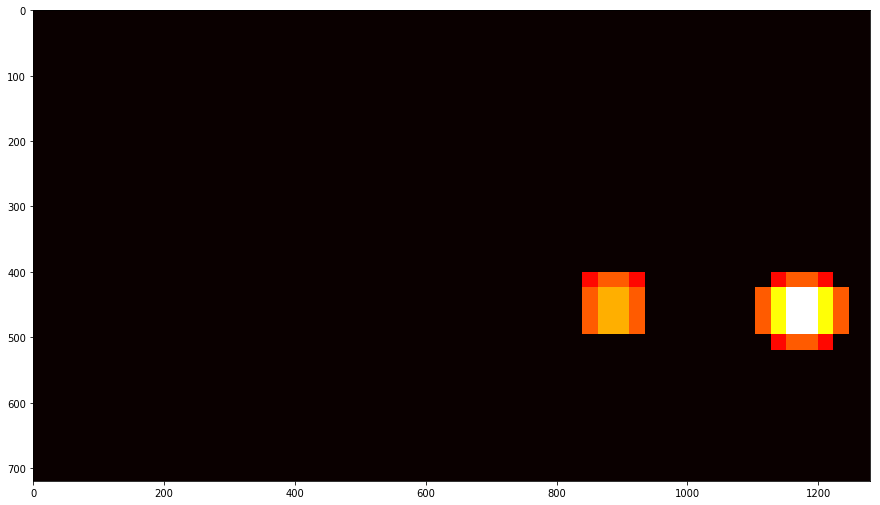

In [187]:
# Display output of add_heat() on sample image
thresh_heat_img = apply_threshold(heat_img, 2)
plt.figure(figsize=(15,15))
plt.imshow(heat_img, cmap='hot')
plt.show()

### Apply SciPy Labels to Thresholded Heatmap

Show Output of labels()

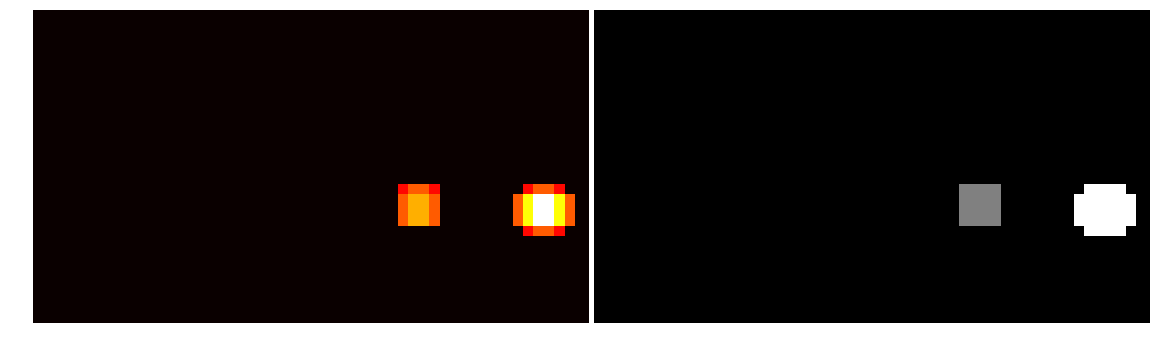

In [188]:
# Import labels from scipy
from scipy.ndimage.measurements import label

# Apply labels() to heatmap
labels = label(thresh_heat_img)

# Show output
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
fig.subplots_adjust(hspace=.004, wspace=.01)
ax1.imshow(heat_img, cmap='hot') #heatmap
ax1.axis('off')
ax2.imshow(labels[0], cmap='gray') #labels
ax2.axis('off')

fig.savefig('./examples/labels.png', bbox_inches='tight')

### Draw Bounding Boxes for Labels

Define Function to Fit Boxes to Each Label

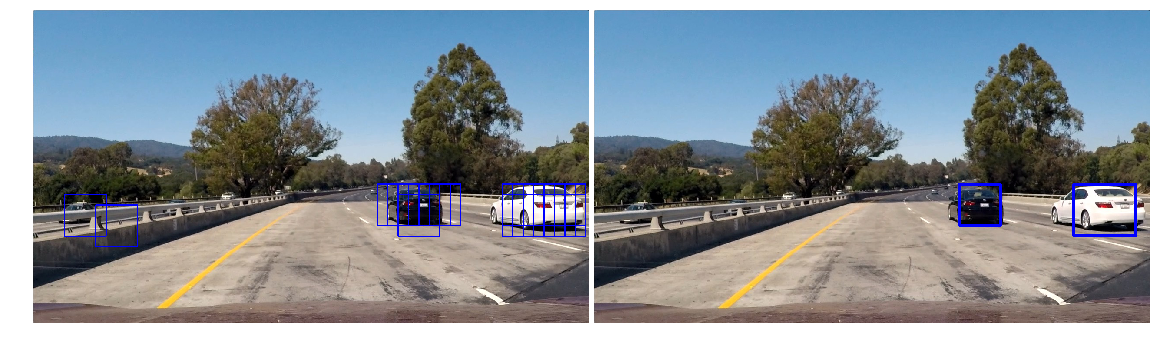

In [189]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
                (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(sample_img), labels)


# Show output
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
fig.subplots_adjust(hspace=.004, wspace=.01)
ax1.imshow(output_img) #multi-box
ax1.axis('off')
ax2.imshow(draw_img) #final_out
ax2.axis('off')

fig.savefig('./examples/final_output.png', bbox_inches='tight')

#### Create 'pipeline' Function to Run Full Pipeline

In [251]:
def pipeline(img):
    # Create list to add bounding boxes to
    bbox_list = []
    
    # Search space parameters
    ystart_list = [400, 400, 400, 425, 450, 460]
    ystop_list = [500, 540, 575, 625, 700, 720]
    scale_list = [1, 1.5, 2, 2.5, 3, 4]

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[0], 
                               ystop=ystop_list[0], 
                               scale=scale_list[0],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[1], 
                               ystop=ystop_list[1], 
                               scale=scale_list[1],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[2], 
                               ystop=ystop_list[2], 
                               scale=scale_list[2],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[3], 
                               ystop=ystop_list[3], 
                               scale=scale_list[3],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[4], 
                               ystop=ystop_list[4], 
                               scale=scale_list[4],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[5], 
                               ystop=ystop_list[5], 
                               scale=scale_list[5],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, bbox_list)
    heatmap_img = apply_threshold(heatmap_img, 3)
    labels = label(heatmap_img)
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [253]:
def class_pipeline(img):
    # Create list to add bounding boxes to
    bbox_list = []
    
    # Search space parameters
    ystart_list = [400, 400, 400, 425, 450, 460]
    ystop_list = [500, 540, 575, 625, 700, 720]
    scale_list = [1, 1.5, 2, 2.5, 3, 4]

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[0], 
                               ystop=ystop_list[0], 
                               scale=scale_list[0],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[1], 
                               ystop=ystop_list[1], 
                               scale=scale_list[1],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[2], 
                               ystop=ystop_list[2], 
                               scale=scale_list[2],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[3], 
                               ystop=ystop_list[3], 
                               scale=scale_list[3],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[4], 
                               ystop=ystop_list[4], 
                               scale=scale_list[4],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    bbox_list.append(find_cars(img, 
                               ystart=ystart_list[5], 
                               ystop=ystop_list[5], 
                               scale=scale_list[5],
                               svc=svc, X_scaler=X_scaler, color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               color_channel=color_channel, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, 
                               hog_feat=hog_feat, show_all=False))

    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, bbox_list)
    heatmap_img = apply_threshold(heatmap_img, 3)
    labels = label(heatmap_img)
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    
    return bboxes

#### Apply pipeline() to all Test Images

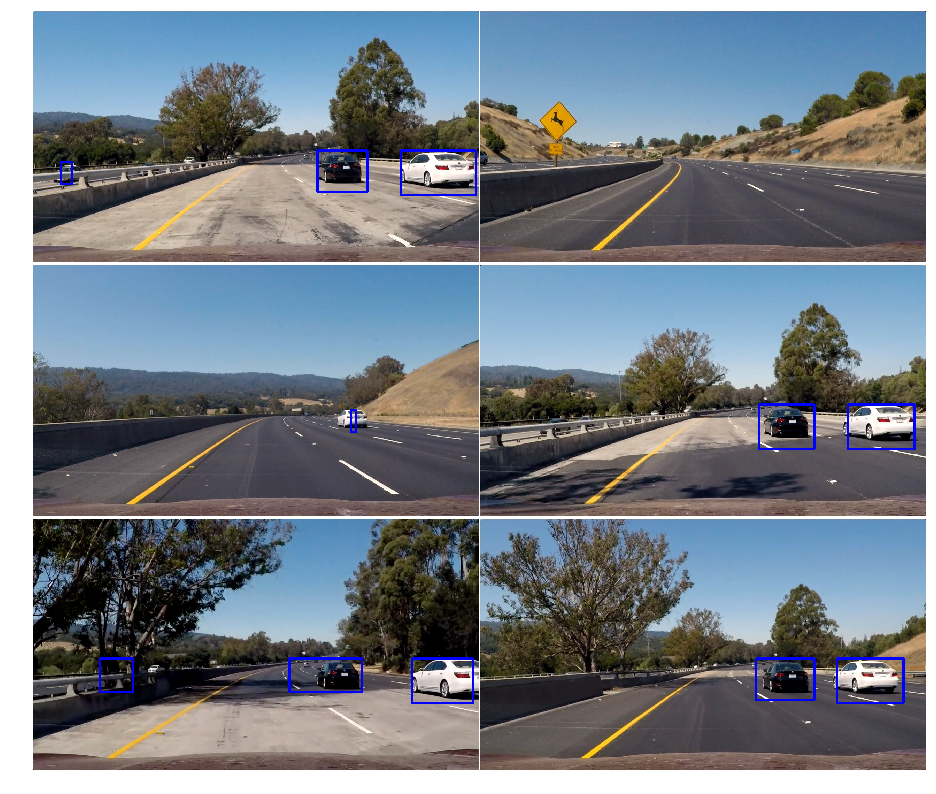

In [252]:
images = glob.glob('./test_images/*')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, img in enumerate(images):
    out = pipeline(mpimg.imread(img))
    axs[i].imshow(out)
    axs[i].axis('off')
fig.savefig('./examples/pipeline_images.png', bbox_inches='tight')

## Vehicle Detection with Video Input

### Video Implementation - First Pass

In [85]:
test_out_file = './output_videos/test_video_out2.mp4'
clip_test = VideoFileClip('./test_videos/test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline2)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_out2.mp4
[MoviePy] Writing video ./output_videos/test_video_out2.mp4


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 38/39 [00:16<00:00,  2.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_out2.mp4 

Wall time: 17.1 s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [263]:
# process video
proj_out_file = './output_videos/project_video.mp4'
clip_proj = VideoFileClip('./test_videos/project_video.mp4')
clip_proj_out = clip_proj.fl_image(pipeline)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4



  2%|█████▍                                                                                                                                                                                                                                                                            | 25/1261 [00:30<24:47,  1.20s/it]


  4%|███████████                                                                                                                                                                                                                                                                       | 51/1261 [01:02<24:19,  1.21s/it]


  6%|████████████████▋                                                                                                                                                                                                                                                                 | 77/1261 [01:33<23:32,  1.19s/it]


  8%|██████████████████████▎                                                                                                                                                                                                                                                          | 103/1261 [02:05<23:44,  1.23s/it]


 10%|███████████████████████████▉                                                                                                                                                                                                                                                     | 129/1261 [02:36<22:40,  1.20s/it]


 12%|█████████████████████████████████▌                                                                                                                                                                                                                                               | 155/1261 [03:08<22:04,  1.20s/it]


 14%|███████████████████████████████████████▏                                                                                                                                                                                                                                         | 181/1261 [03:39<22:17,  1.24s/it]


 16%|████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 207/1261 [04:11<21:49,  1.24s/it]


 18%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 233/1261 [04:43<20:55,  1.22s/it]


 21%|████████████████████████████████████████████████████████                                                                                                                                                                                                                         | 259/1261 [05:15<20:21,  1.22s/it]


 23%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 285/1261 [05:46<19:42,  1.21s/it]


 25%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                             | 311/1261 [06:18<19:22,  1.22s/it]


 27%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                        | 337/1261 [06:50<18:46,  1.22s/it]


 29%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 363/1261 [07:22<18:14,  1.22s/it]


 31%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 389/1261 [07:53<17:45,  1.22s/it]


 33%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 415/1261 [08:25<17:17,  1.23s/it]


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 441/1261 [08:57<16:33,  1.21s/it]


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 467/1261 [09:30<16:07,  1.22s/it]


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 493/1261 [10:02<15:28,  1.21s/it]


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 519/1261 [10:33<15:14,  1.23s/it]


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 545/1261 [11:05<14:38,  1.23s/it]


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 571/1261 [11:36<14:01,  1.22s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 597/1261 [12:09<13:53,  1.25s/it]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 623/1261 [12:40<12:59,  1.22s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 649/1261 [13:12<12:23,  1.21s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 675/1261 [13:43<11:57,  1.22s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 701/1261 [14:15<11:23,  1.22s/it]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 727/1261 [14:46<10:49,  1.22s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 753/1261 [15:18<10:24,  1.23s/it]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 779/1261 [15:49<09:42,  1.21s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 805/1261 [16:21<09:12,  1.21s/it]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 831/1261 [16:53<08:38,  1.21s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 857/1261 [17:24<08:12,  1.22s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 883/1261 [17:55<07:35,  1.21s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 909/1261 [18:27<07:06,  1.21s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 935/1261 [18:58<06:34,  1.21s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 961/1261 [19:30<06:07,  1.23s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 987/1261 [20:02<05:45,  1.26s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1013/1261 [20:34<05:06,  1.24s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1039/1261 [21:06<04:33,  1.23s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1065/1261 [21:38<04:03,  1.24s/it]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1091/1261 [22:12<03:53,  1.38s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1117/1261 [22:47<02:51,  1.19s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1143/1261 [23:19<02:34,  1.31s/it]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1169/1261 [23:51<01:51,  1.21s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1195/1261 [24:23<01:26,  1.31s/it]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1221/1261 [24:56<00:50,  1.26s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1247/1261 [25:31<00:20,  1.46s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [25:48<00:01,  1.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

Wall time: 25min 49s


In [264]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))

### Video Implementation - Second Pass

#### Define a 'Dude_Wheres_My_Car' Class to Improve Processing

In [255]:
# Define a class to store data and skip frames
class Dude_Wheres_My_Car():
    def __init__(self, n=1):
        self.frame_counter = 1
        self.bbox_list = collections.deque(maxlen=n) 
        self.process_current = False
        
    def update_counter(self):
        self.frame_counter += 1
    
    def process_check(self):
        if self.frame_counter%2 == 0:
            self.process_current = True
        else:
            self.process_current = False
            
    def update_info(self, bbox_list):
        self.bbox_list.append(bbox_list)

In [261]:
def process_video(img):
    # Update frame count and check processing flag
    car_search.update_counter()
    car_search.process_check()
    
    # Either process current frame, or return previous bounding boxes
    if car_search.process_current == True:
        # run pipeline, return output image & bbox list
        bbox_list = class_pipeline(img)
        
        # update class with new bbox info
        car_search.update_info(bbox_list)
        
    else:
        bbox_list = car_search.bbox_list
    
    #heatmap_img = np.zeros_like(img[:,:,0])
    #heatmap_img = add_heat(heatmap_img, bbox_list)
    #heatmap_img = apply_threshold(heatmap_img, 10)
    #labels = label(heatmap_img)
    draw_img = draw_boxes(np.copy(img), bbox_list)

    return draw_img

In [262]:
# create instance of class
car_search = Dude_Wheres_My_Car()

# process video
proj_out_file = './output_videos/project_video.mp4'
clip_proj = VideoFileClip('./test_videos/project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


  0%|                                                                                                                                                                                                                                                                                           | 0/1261 [00:00<?, ?it/s]

IndexError: list index out of range

In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))